# Codebase Predictive Modelling
## DS4A / Colombia - Cohort 6
## Team 162

Ariadna De Ávila, Nicolás Gaona, Ricardo Peña, Daniel Restrepo, David Romero, Fredy Salazar, Geronimo Valencia

# 1. Preliminaries

One of the main objectives of this project is to build a model that could predict whether a sale transaction would take place in the traditional 'Presential Channel' or 'Digital Channel', having as perspective that knowing forehand the nature of this transactions will help H&M's develop more effective marketing strategies and gain substantial insight on customer behavior and sale dinamycs.

## 1.1. Packages needed

In [ ]:
#import libraries
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
import pickle
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

## 1.2. Datasets import

In [ ]:
#import datasets
customers=pd.read_csv('customers.csv')
articles=pd.read_csv('articles.csv')
transactions_train=pd.read_csv('transactions_train.csv')

# 2. Data wrangling and preprocessing

## 2.1. Data sample selection and wrangling

**Sampling**

Due to a huge availability on information (+30 million records) on the transactions table and constraints in computational capacity the team took the decision to use just 10 million records to train predictive models. This sample statistically comes from the same distribution in comparison to the overall raw information.

**Transformations and data merging**

In feature `sales_channel_id` there were found some erroneous records of channels that had value of '2', an uknown type of channel. Given that in our exploratory analisys less than 0.5% of the records had this behaviour, the team decided to replace this values with class '0', this way the bigger class in the respose variable will absorb all those records.

As shown in the EDA, valuable information could be extracted from date of transactions, which led to create new varaibles that held record of the year and month when any given sale transaction took place.

Raw information seem to came from a relational database, so joining and merging data using primary and foreing keys is neccessary, also a simple ordinal encoding based on dictionaries was used to mask the categorial information of features such as colors, groups and garments.

**Missing data handling policy**

Due to small proportion of missing values, the decision to remove rows of records where any `null` value where to be found were eliminated.

In [ ]:
#Preprocessing
transactions_train_model=transactions_train.iloc[0:10000000]
transactions_train_model['sales_channel_id'].mask(transactions_train_model['sales_channel_id'] == 2, 0, inplace=True)
transactions_train_model['month']=pd.DatetimeIndex(transactions_train_model['t_dat']).month
transactions_train_model['year']=pd.DatetimeIndex(transactions_train_model['t_dat']).year
merged_data = pd.merge(transactions_train_model,customers[['customer_id','age']], on ='customer_id')
merged_data = pd.merge(merged_data,articles[['article_id','colour_group_name','index_group_name','garment_group_name']], on ='article_id')
merged_data.dropna(inplace=True)
encoder_garments ={'Under-, Nightwear':1, 'Blouses':2, 'Knitwear':3, 'Special Offers':4,
       'Shoes':5, 'Accessories':6, 'Skirts':7, 'Trousers':8, 'Dresses Ladies':9,
       'Jersey Basic':10, 'Jersey Fancy':11, 'Socks and Tights':12, 'Swimwear':13,
       'Trousers Denim':14, 'Unknown':15, 'Woven/Jersey/Knitted mix Baby':16,
       'Outdoor':17, 'Shirts':18, 'Dressed':19, 'Dresses/Skirts girls':20, 'Shorts':21}
encoder_colors ={'Black':1, 'Light Pink':2, 'Light Blue':3, 'Pink':4, 'Dark Green':5,
       'Dark Grey':6, 'Grey':7, 'Dark Blue':8, 'Dark Pink':9, 'Light Red':10,
       'Beige':11, 'Dark Yellow':12, 'Green':13, 'Gold':14, 'White':15, 'Light Grey':16,
       'Red':17, 'Orange':18, 'Light Orange':19, 'Dark Turquoise':20, 'Other':21,
       'Yellowish Brown':22, 'Dark Red':23, 'Light Beige':24, 'Yellow':25,
       'Turquoise':26, 'Blue':27, 'Other Pink':28, 'Dark Beige':29, 'Greenish Khaki':30,
       'Off White':31, 'Light Green':32, 'Silver':33, 'Light Yellow':34,
       'Light Purple':35, 'Dark Purple':36, 'Purple':37, 'Greyish Beige':38,
       'Light Turquoise':39, 'Other Blue':40, 'Dark Orange':41, 'Other Turquoise':42,
       'Bronze/Copper':43, 'Other Red':44, 'Transparent':45, 'Other Yellow':46,
       'Other Orange':47, 'Other Purple':48, 'Unknown':49, 'Other Green':50}
encoder_index_groups = {'Ladieswear':1, 'Divided':2, 'Menswear':3, 'Sport':4, 'Baby/Children':5}
merged_data['colors'] = merged_data['colour_group_name'].replace(encoder_colors)
merged_data['group_indexes'] = merged_data['index_group_name'].replace(encoder_index_groups)
merged_data['garments'] = merged_data['garment_group_name'].replace(encoder_garments)
merged_data

C:\Users\David Romero\AppData\Local\Temp\ipykernel_7952\2366375762.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  transactions_train_model['sales_channel_id'].mask(transactions_train_model['sales_channel_id'] == 2, 0, inplace=True)
C:\Users\David Romero\AppData\Local\Temp\ipykernel_7952\2366375762.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  transactions_train_model['month']=pd.DatetimeIndex(transactions_train_model['t_dat']).month
C:\Users\David Romero\AppData\Local\Temp\ipykernel_7952\2366375762.py:5: SettingWithCopyWarning: 
A value is trying to be

,t_dat,customer_id,article_id,price,sales_channel_id,month,year,age,colour_group_name,index_group_name,garment_group_name,colors,group_indexes,garments
0,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,663713001,0.050831,0,9,2018,24.0,Black,Ladieswear,"Under-, Nightwear",1,1,1
1,2018-09-24,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,663713001,0.050831,0,9,2018,24.0,Black,Ladieswear,"Under-, Nightwear",1,1,1
2,2018-11-05,1385e5f3a2d3dbd21237f91faf81254a6d96de31b07b0b...,663713001,0.050831,0,11,2018,25.0,Black,Ladieswear,"Under-, Nightwear",1,1,1
3,2018-11-05,1385e5f3a2d3dbd21237f91faf81254a6d96de31b07b0b...,663713001,0.050831,0,11,2018,25.0,Black,Ladieswear,"Under-, Nightwear",1,1,1
4,2018-09-20,3681748607f3287d2c3a65e00bb5fb153de30e9becf158...,663713001,0.049475,0,9,2018,30.0,Black,Ladieswear,"Under-, Nightwear",1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9999995,2019-05-08,2bc18e46bc8ab674c9e7cb025e72206a2e798b095b411a...,645709007,0.024237,0,5,2019,23.0,Black,Divided,Jersey Fancy,1,2,11
9999996,2019-05-08,551ce832a26850c968378ad1628169ce089bbf67cd9b15...,753210005,0.016932,1,5,2019,21.0,Pink,Divided,Jersey Fancy,4,2,11
9999997,2019-05-08,82e54f34170802037f1a62dadfb8b5039ce15d96f57a79...,715608003,0.025407,1,5,2019,30.0,Dark Blue,Menswear,Shirts,8,3,18
9999998,2019-05-08,903b4db06ed0e5f4e8d1aae5fba8017af236d45e53eec6...,794877001,0.022017,0,5,2019,57.0,Black,Ladieswear,Accessories,1,1,6


## 2.2. Defining response variable as 'y' and predictor features as matrix 'X'

**Response variable**: `sales_channel_id` where 0 is 'Presential Channel' and 1 is 'Digital Channel'
<br>
**Predictor features**: `price`,`month`,`year`,`age`,`colors`,`groups`,`garments`

In [ ]:
# Set definition for target variable and predictor features
y = merged_data.sales_channel_id
X = merged_data.drop(columns=['t_dat','sales_channel_id','customer_id','article_id','colour_group_name','index_group_name','garment_group_name'])

In [ ]:
X

,price,month,year,age,colors,group_indexes,garments
0,0.050831,9,2018,24.0,1,1,1
1,0.050831,9,2018,24.0,1,1,1
2,0.050831,11,2018,25.0,1,1,1
3,0.050831,11,2018,25.0,1,1,1
4,0.049475,9,2018,30.0,1,1,1
...,...,...,...,...,...,...,...
9999995,0.024237,5,2019,23.0,1,2,11
9999996,0.016932,5,2019,21.0,4,2,11
9999997,0.025407,5,2019,30.0,8,3,18
9999998,0.022017,5,2019,57.0,1,1,6


## 2.3. Splitting up Train and Test sets

For training models the 75% of the whole X,y sets was used. The other 25% was used to evaluate predictive performance.

In [ ]:
# Train and test set partition using 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1993)

## 2.4. Fitting Predictive Models

During EDA no linear association between variables were detected, giving hint that usual classification models such as Logistic Regression would not be a good representation for problem in progress.

### 2.4.1. Decision Tree and Random Forest classification algorithms

Decision Tree classification model was the first alternative to predict, also due to Random Forest classification algorithm to be a more robust and comprehensive use of decision trees this technique was also implemented using the sklearn package.
As shown below there is an average classification power of 70.3% for both models using ROC AUC as performance metric and a 5-fold cross validation strategy.

In [ ]:
# Decision Tree 
tree_clf = DecisionTreeClassifier(class_weight='balanced', max_depth=14)
# Random Forest
rf_clf = RandomForestClassifier(max_depth=10, min_samples_leaf=30, n_estimators=150, n_jobs=-1)
auc_tree = cross_val_score(tree_clf, X, y, cv=5, scoring = "roc_auc").mean()
print('Decision tree would give an AUC of:', auc_tree)

Decision tree would give an AUC of: 0.7032989887987715


In [ ]:
auc_rf = cross_val_score(rf_clf, X, y, cv=5, scoring = "roc_auc").mean()
print('Random Forest would give an AUC of:', auc_rf)

Random Forest would give an AUC of: 0.7031061684524931


### 2.4.2. Training and export models to external callable files

It is one important feature of this project to generate a tool that may predict the channel of a particular sale, for this purpose the models are exported to files named `tree_model.sav` and `rf_model.sav` that will be used in the interactive interface.

In [ ]:
# Decision Tree training and export
tree_clf.fit(X_train, y_train)
#pickle.dump(tree_clf, open('tree_model.sav', 'wb'))

DecisionTreeClassifier(class_weight='balanced', max_depth=14)

In [ ]:
# Random Forest training and export
rf_clf.fit(X_train, y_train)
#pickle.dump(rf_clf, open('rf_model.sav', 'wb'))

RandomForestClassifier(max_depth=10, min_samples_leaf=30, n_estimators=150,
                       n_jobs=-1)

### 2.4.3. Performance and conclusions

In [ ]:
#auc and confussion matrix for decision tree

In [ ]:
probabilities_dt = tree_clf.predict_proba(X_test)
predictions_dt= tree_clf.predict(X_test)

In [ ]:
false_positive_rate1, true_positive_rate1, threshold1 = roc_curve(y_test, predictions_dt)
print('roc_auc_score for Decision Tree: ', roc_auc_score(y_test, predictions_dt))

roc_auc_score for Decision Tree:  0.6748483774932196


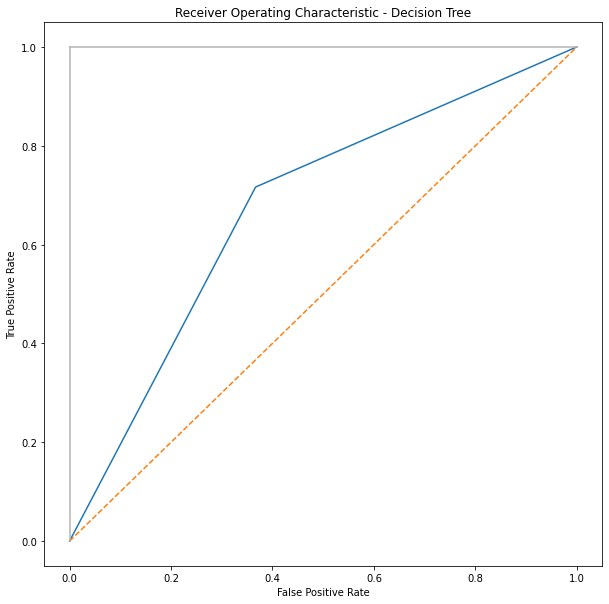

In [ ]:
plt.subplots(1, figsize=(10,10))
plt.title('Receiver Operating Characteristic - Decision Tree')
plt.plot(false_positive_rate1, true_positive_rate1)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show() 

In [ ]:
print(confusion_matrix(y_test, predictions_dt))
print(classification_report(y_test, predictions_dt))

[[1092642  632789]
 [ 215615  544769]]
              precision    recall  f1-score   support

           0       0.84      0.63      0.72   1725431
           1       0.46      0.72      0.56    760384

    accuracy                           0.66   2485815
   macro avg       0.65      0.67      0.64   2485815
weighted avg       0.72      0.66      0.67   2485815



In [ ]:
#auc and confussion matrix for random forest.

In [ ]:
probabilities_rf = rf_clf.predict_proba(X_test)
predictions_rf= rf_clf.predict(X_test)

In [ ]:
false_positive_rate2, true_positive_rate2, threshold2 = roc_curve(y_test, predictions_rf)
print('roc_auc_score for Random Forest: ', roc_auc_score(y_test, predictions_rf))

roc_auc_score for Random Forest:  0.5554704595917159


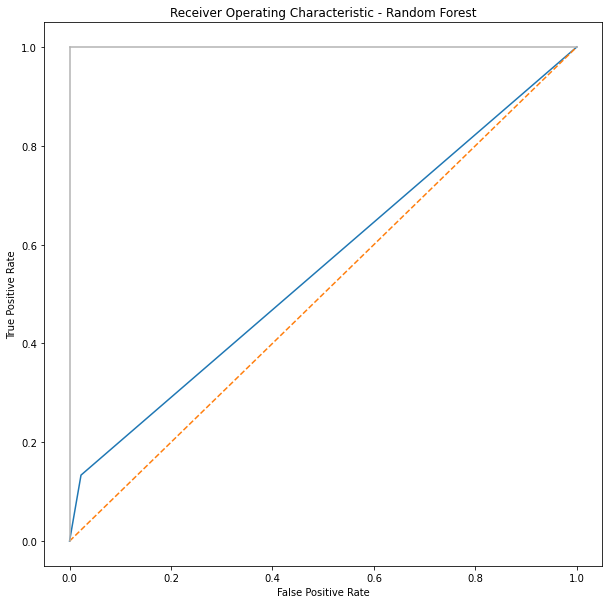

In [ ]:
plt.subplots(1, figsize=(10,10))
plt.title('Receiver Operating Characteristic - Random Forest')
plt.plot(false_positive_rate2, true_positive_rate2)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show() 

In [ ]:
print(confusion_matrix(y_test, predictions_rf))
print(classification_report(y_test, predictions_rf))

[[1686512   38919]
 [ 658875  101509]]
              precision    recall  f1-score   support

           0       0.72      0.98      0.83   1725431
           1       0.72      0.13      0.23    760384

    accuracy                           0.72   2485815
   macro avg       0.72      0.56      0.53   2485815
weighted avg       0.72      0.72      0.64   2485815



In [ ]:
#About the the AUC, CM and metrics

Both models have similar AUC but the basic tree model gets better results overall, to determine which sales channel to use is recommended to use the Decision Tree model.
More models can be trained or the actual models can be improved if a better AUC is desired.
The ROC plot supports the results from the AUC, with a higher AUC, a wider and upper curve will be generated.
The confusion matrix for the Decision Tree is getting several predictions for the zero class (digital), 1092640 of the 2485815 sample test are predicted as
zero and are actual zero class (True Negatives). We have 632791 false negatives (predicted as zero but actual one), this may be a high value but is actual
acceptable since we want to give priority to the zero class, this is, an article is cheaper and easiest to sell on the digital channel.
The true positives are low compared to the true negatives, the model is not predicting very good to the channel 1
 (we can see the 0.46 precision against the 0.84 precision of the zero class). Finally we have low false positives and they are not representative for our purpose.
For the Random forest model we have similar conclusions getting better/worse XXXX true negatives and false negatives.